<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/NLP/ULMFiT_fastai_Twitter_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# import libraries
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
#!wget https://www.kaggle.com/crowdflower/twitter-airline-sentiment

--2019-12-27 07:08:20--  https://www.kaggle.com/crowdflower/twitter-airline-sentiment
Resolving www.kaggle.com (www.kaggle.com)... 35.244.233.98
Connecting to www.kaggle.com (www.kaggle.com)|35.244.233.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘twitter-airline-sentiment’

twitter-airline-sen     [ <=>                ] 113.56K  --.-KB/s    in 0.06s   

2019-12-27 07:08:21 (1.72 MB/s) - ‘twitter-airline-sentiment’ saved [116289]



In [6]:
df1 = pd.read_csv('/content/Tweets.csv')
df1.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [0]:
# create a dataframe
df = pd.DataFrame({'label':df1.airline_sentiment,
                   'text':df1.text})

In [19]:
df.head()

,label,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [20]:
df.shape

(14640, 2)

In [21]:
df['label'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: label, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.4, random_state = 12)

In [23]:
df_trn.shape, df_val.shape

((8784, 2), (5856, 2))

### Preprocessing

Not needed as we do not need tokens as we are going to use the sentence embeddings and the complete sentence matters.

### Data Preparation

In [35]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


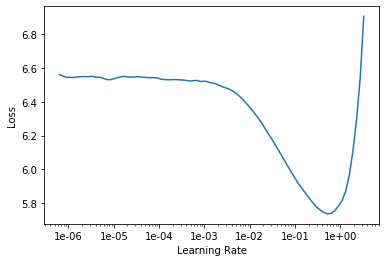

In [37]:
learn.lr_find()
learn.recorder.plot()

In [38]:
# train the learner object
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.676681,4.568896,0.209277,00:05
1,4.571528,3.890135,0.262591,00:05
2,4.041032,3.801507,0.269761,00:05
3,3.734378,3.774297,0.273556,00:05
4,3.555375,3.767890,0.274309,00:05


In [0]:
learn.save_encoder('ft_enc')

In [40]:
my_fbeta = FBeta(beta=1,average='macro')
learn.metrics = [accuracy, my_fbeta, Precision(average='macro'),Recall(average='macro'),FBeta(average='macro')]
learn.metrics

[<function fastai.metrics.accuracy>,
 FBeta(average='macro', pos_label=1, eps=1e-09, beta=1),
 Precision(average='macro', pos_label=1, eps=1e-09),
 Recall(average='macro', pos_label=1, eps=1e-09),
 FBeta(average='macro', pos_label=1, eps=1e-09, beta=2)]

In [41]:
learn = text_classifier_learner(data_clas,arch=AWD_LSTM, drop_mult=0.7,metrics = [accuracy, my_fbeta])
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8784 items)
x: TextList
xxbos @americanair xxmaj why is it ok that no - one can help me with the bag you lost on my honeymoon xxunk ago , this is not responsible or professional,xxbos @united xxrep 5 < xxrep 7 - shoddy customer service . xxmaj of no use xxunk . # xxunk,xxbos “ @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / xxunk ” # xxunk,xxbos @southwestair is that xxunk,xxbos @americanair xxmaj tired of sitting on a delayed # xxunk again and again computer down
y: CategoryList
negative,negative,neutral,neutral,negative
Path: .;

Valid: LabelList (5856 items)
x: TextList
xxbos @americanair i filled out that whole form before receiving a poor poor response . xxmaj is there no direct email address in reply ?,xxbos @usairways xxmaj some of my 4 kids are anxious . xxmaj husband and i ca n't sit with all 4 with current xxunk . xxmaj no warning that our 6 seats changed .,xxbos @southwestair when are you opening the flights be

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


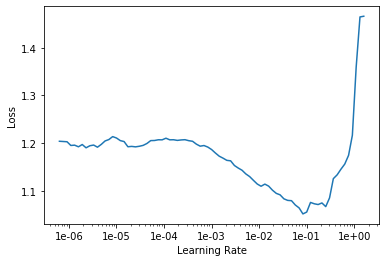

In [42]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.743620,0.663829,0.719262,0.544927,00:05
1,0.712990,0.555603,0.773907,0.669861,00:05
2,0.679496,0.572419,0.765369,0.650115,00:05


In [44]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2
row_0,,,
0,3554,742,354
1,52,376,39
2,65,122,552


In [45]:
print("Process completed ")


Process completed 
